# 1. Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import operator

import imageio
import glob
import random
import time

# 2. Write Function

## 2.1 Linear Regression

In [2]:
def LR_find_r(X, Y):
    Xmean = X.mean()
    Ymean = Y.mean()
    fraction = ((X - Xmean)*(Y - Ymean)).sum()
    denorminator = np.sqrt(((X - Xmean)**2).sum()*((Y - Ymean)**2).sum())
    r = fraction/denorminator
    return r

In [3]:
def LR_find_ab(X, Y):
    XY = X*Y
    X2 = X**2
    Xmean = X.mean()
    Ymean = Y.mean()
    XYmean = XY.mean()
    X2mean = X2.mean()
    denorminator = X2mean - Xmean**2
    a = (XYmean - Xmean*Ymean)/denorminator
    b = (X2mean*Ymean - Xmean*XYmean)/denorminator
    return a, b

In [4]:
def LR_find_Yhat(X, a, b):
    Yhat = a*X + b
    return Yhat

## 2.2 Multiple Regression

In [5]:
def MR_create_Xb(X):
    N = X.shape[0]
    ones = np.ones([N, 1])
    Xb = np.hstack([ones, X])
    return Xb

In [6]:
def MR_find_W(X, Y):
    Xb = MR_create_Xb(X)
    front = inv(np.dot(Xb.T, Xb))
    back = np.dot(X.T, Y)
    W = np.dot(front, back)
    return W

In [7]:
def MR_find_Yhat(X, W):
    Xb = MR_create_Xb(X)
    Yhat = np.dot(Xb, W)
    return Yhat

In [8]:
def MR_find_W_local(X, Y, epoch = 1000, lr = 0.01, batch_size = 64, lambda1 = 0, lambda2 = 0):
    Xb = MR_create_Xb(X)
    N = Xb.shape[0]
    D_1 = Xb.shape[1]
    W = np.random.randn(D_1, 1)/np.sqrt(D_1)
    error_list = []
    for i in range(epoch):
        if batch_size == N:
            Yhat = MR_find_Yhat(X, W)
            error = find_error(Y, Yhat, 'SSE')
            error_list.append(error)
            S = np.dot(Xb.T, Y - Yhat)
        elif batch_size != N:
            X_mb, Y_mb = shuffle(X, Y, N, batch_size)
            Xb_mb = MR_create_Xb(X_mb)
            Yhat_mb = MR_find_Yhat(X_mb, W)
            error = find_error(Y_mb, Yhat_mb, 'SSE')
            error_list.append(error)
            S = np.dot(Xb_mb.T, Y_mb - Yhat_mb)
        W = W + (lr/batch_size)*S - lambda1*np.sign(W) - lambda2*W
    return W, error_list

## 2.3 Logistic Regression

In [9]:
def LoR_create_Xb(X):
    N = X.shape[0]
    ones = np.ones([N, 1])
    Xb = np.hstack([ones, X])
    return Xb

In [10]:
def LoR_find_W_local(X, Y, epoch = 1000, lr = 1, batch_size = 64, lambda1 = 0, lambda2 = 0):
    Xb = LoR_create_Xb(X)
    N = Xb.shape[0]
    D_1 = Xb.shape[1]
    W = np.random.randn(D_1, 1)/np.sqrt(D_1)
    error_list = []
    for i in range(epoch):
        if batch_size == N:
            Yhat = LoR_find_Yhat(X, W)
            error = find_error(Y, Yhat, 'Entropy')
            error_list.append(error)
            S = np.dot(Xb.T, Y - Yhat)
        elif batch_size != N:
            X_mb, Y_mb = shuffle(X, Y, N, batch_size)
            Xb_mb = LoR_create_Xb(X_mb)
            Yhat_mb = LoR_find_Yhat(Xb_mb, W)
            error = find_error(Y_mb, Yhat_mb, 'Entropy')
            error_list.append(error)
            S = np.dot(Xb_mb.T, Y_mb - Yhat_mb)
        W = W + (lr/batch_size)*S - lambda1*np.sign(W) - lambda2*W
    return W, error_list

In [11]:
def LoR_find_Yhat(X, W):
    Xb = LoR_create_Xb(X)
    Z = np.dot(Xb, W)
    Yhat = 1/(1 + np.exp(-Z))
    return Yhat

In [12]:
def LoR_find_W_local_mul_class(X, Y, epoch = 1000, lr = 1, batch_size = 64, lambda1 = 0, lambda2 = 0):
    Xb = LoR_create_Xb(X)
    N = Xb.shape[0]
    D_1 = Xb.shape[1]
    K = Y.shape[1]
    W = np.random.randn(D_1, K)/np.sqrt(D_1)
    error_list = []
    for i in range(epoch):
        if batch_size == N:
            Yhat = LoR_find_Yhat_mul_class(X, W)
            error = find_error(Y, Yhat, 'Entropy')
            error_list.append(error)
            S = np.dot(Xb.T, Y-Yhat)
        elif batch_size != N:
            X_mb, Y_mb = shuffle(X, Y, N, batch_size)
            Xb_mb = LoR_create_Xb(X_mb)
            Yhat_mb = LoR_find_Yhat_mul_class(X_mb, W)
            error = find_error(Y_mb, Yhat_mb, 'Entropy')
            error_list.append(error)
            S = np.dot(Xb_mb.T, Y-mb - Yhat_mb)
        W = W + (lr/batch_size)*S - lambda1*np.sign(W) - lambda2*W
    return W, error_list

In [13]:
def LoR_find_Yhat_mul_class(X, W):
    Xb = LoR_create_Xb(X)
    Z = np.dot(Xb, W)
    Yhat = np.exp(Z)/np.exp(Z).sum(axis=1, keepdims = True)
    return Yhat

## 2.4 Neural Network

In [14]:
def NN_create_WB(A0, HL):
    W = []
    B = []
    for i in range(len(HL)):
        if i == 0:
            W_i = np.random.randn(A0.shape[1], HL[0])/np.sqrt(HL[0])
        else:
            W_i = np.random.randn(HL[i-1], HL[i])/np.sqrt(HL[i])
        B_i = np.random.randn(1, HL[i])/np.sqrt(HL[i])
        W.append(W_i)
        B.append(B_i)
    return W, B

In [15]:
def NNR_find_WB(A0, T, HL, AF, epoch = 1000, lr = 0.01, batch_size = 64, lambda1 = 0, lambda2 = 0, dropout = False, prob_drop = [0]):
    L = len(HL)
    N = A0.shape[0]
    W, B = NN_create_WB(A0, HL)
    error_list = []
    for i in range(epoch):
        if batch_size == N:
            Z, A = NN_forward(A0, W, B, AF)
            error = find_error(T, A[-1], 'SSE')
            error_list.append(error)
            SW, SB = NNR_backpropagation(A0, W, B, Z, A, T, AF, dropout, prob_drop)
        elif batch_size != N:
            A0_mb, T_mb = shuffle(A0, T, N, batch_size)
            Z_mb, A_mb = NN_forward(A0_mb, W, B, AF)
            error = find_error(T_mb, A_mb[-1], 'SSE')
            error_list.append(error)
            SW, SB = NNR_backpropagation(A0_mb, W, B, Z_mb, A_mb, T_mb, AF, dropout, prob_drop)
        for j in range(L):
            W[j] = W[j] + (lr/batch_size)*SW[j] - lambda1*np.sign(W[j]) - lambda2*W[j]
            B[j] = B[j] + (lr/batch_size)*SB[j] - lambda1*np.sign(B[j]) - lambda2*B[j]
    return W, B, error_list

In [16]:
def NNC_find_WB(A0, T, HL, AF, epoch = 1000, lr = 0.01, batch_size = 64, lambda1 = 0, lambda2 = 0, dropout = False, prob_drop = [0]):
    L = len(HL)
    N = A0.shape[0]
    W, B = NN_create_WB(A0, HL)
    error_list = []
    for i in range(epoch):
        if batch_size == N:
            Z, A = NN_forward(A0, W, B, AF)
            error = find_error(T, A[-1], 'Entropy')
            error_list.append(error)
            SW, SB = NNC_backpropagation(A0, W, B, Z, A, T, AF, dropout, prob_drop)
        elif batch_size != N:
            A0_mb, T_mb = shuffle(A0, T, N, batch_size)
            Z_mb, A_mb = NN_forward(A0_mb, W, B, AF)
            error = find_error(T_mb, A_mb[-1], 'Entropy')
            error_list.append(error)
            SW, SB = NNC_backpropagation(A0_mb, W, B, Z_mb, A_mb, T_mb, AF, dropout, prob_drop)
        for j in range(L):
            W[j] = W[j] + (lr/batch_size)*SW[j] - lambda1*np.sign(W[j]) - lambda2*W[j]
            B[j] = B[j] + (lr/batch_size)*SB[j] - lambda1*np.sign(B[j]) - lambda2*B[j]
    return W, B, error_list

In [17]:
def NN_forward(A0, W, B, AF):
    Z = []
    A = []
    for i in range(len(AF)):
        if i == 0:
            Z_i = np.dot(A0, W[i]) + B[i]
        else:
            Z_i = np.dot(A[-1], W[i]) + B[i]
        A_i = NN_compute_A(Z_i, AF[i])
        Z.append(Z_i)
        A.append(A_i)
    return Z, A

In [18]:
def NN_compute_A(Z_i, af):
    if type(af) == str:
        if af == 'sigmoid':
            A_i = 1/(1 + np.exp(-Z_i))
        elif af == 'tanh':
            A_i = (np.exp(Z_i) - np.exp(-Z_i))/(np.exp(Z_i) + np.exp(-Z_i))
        elif af == 'ReLU':
            A_i = Z_i * (Z_i > 0)
        elif af == 'softmax':
            A_i = np.exp(Z_i)/np.exp(Z_i).sum(axis=1, keepdims = True)
    elif type(af) == list:
        if af[0] == 'PReLU':
            A_i = Z_i * (Z_i > 0) + af[1] * Z_i * (Z_i <= 0)
    return A_i

In [19]:
def NNR_backpropagation(A0, W, B, Z, A, T, AF, dropout, prob_drop):
    L = len(AF)
    SW = []
    SB = []
    if dropout == True:
        DN = NN_random_DN(HL, prob_drop)
    for i in range(L - 1, -1, -1):
        if i == L - 1:
            Delta_i = T - A[-1]
        else:
            Delta_i = np.dot(Err_i, W[i+1].T)
        Diff_i = NN_compute_Diff(Z[i], A[i], AF[i])
        Err_i = NN_compute_Err(Delta_i, Diff_i)
        
        if dropout == False:
            if i != 0:
                SW_i = np.dot(A[i-1].T, Err_i)
            else:
                SW_i = np.dot(A0.T, Err_i)
            SB_i = Err_i.sum(axis=0)
        elif dropout == True:
            if i != 0:
                SW_i = np.dot((A[i-1]*DN[i-1]).T, Err_i)
            else:
                SW_i = np.dot(A0.T, Err_i)
            if i == L - 1:
                SB_i = Err_i.sum(axis=0)
            else:
                SB_i = (Err_i*DN[i]).sum(axis=0)
                
        SW.append(SW_i)
        SB.append(SB_i)
    return SW[::-1], SB[::-1]

In [20]:
def NNC_backpropagation(A0, W, B, Z, A, T, AF, dropout, prob_drop):
    L = len(AF)
    SW = []
    SB = []
    if dropout == True:
        DN = NN_random_DN(HL, prob_drop)
    for i in range(L - 1, -1, -1):
        if i == L - 1:
            Delta_i = T - A[i]
            Diff_i = 1
        else:
            Delta_i = np.dot(Err_i, W[i+1].T)
            Diff_i = NN_compute_Diff(Z[i], A[i], AF[i])
        Err_i = NN_compute_Err(Delta_i, Diff_i)
        
        if dropout == False:
            if i != 0:
                SW_i = np.dot(A[i-1].T, Err_i)
            else:
                SW_i = np.dot(A0.T, Err_i)
            SB_i = Err_i.sum(axis=0)
        elif dropout == True:
            if i != 0:
                SW_i = np.dot((A[i-1]*DN[i-1]).T, Err_i)
            else:
                SW_i = np.dot(A0.T, Err_i)
            if i == L - 1:
                SB_i = Err_i.sum(axis=0)
            else:
                SB_i = (Err_i*DN[i]).sum(axis=0)
        
        SW.append(SW_i)
        SB.append(SB_i)
    return SW[::-1], SB[::-1]

In [21]:
def NN_random_DN(HL, prob_drop):
    DN = []
    for i in range(len(HL)):
        Dropout_Node = np.random.choice([False, True], [1, HL[i]], p = [prob_drop[i], 1 - prob_drop[i]])
        DN.append(Dropout_Node)
    return DN

In [22]:
def NN_compute_Diff(Z_i, A_i, af):
    if type(af) == str:
        if af == 'sigmoid':
            Diff_i = A_i * (1 - A_i)
        elif af == 'tanh':
            Diff_i = 1 - A_i**2
        elif af == 'ReLU':
            Diff_i = (Z_i > 0)
    elif type(af) == list:
        if af[0] == 'PReLU':
            Diff_i = (Z_i > 0) + af[1] * (Z_i <= 0)
    return Diff_i

In [23]:
def NN_compute_Err(Delta_i, Diff_i):
    Err_i = Delta_i * Diff_i
    return Err_i

## 2.5 Error Function

In [24]:
def find_error(Y, Yhat, TypeOfError):
    if TypeOfError == 'SSE':
        error = find_SSE(Y, Yhat)
    elif TypeOfError == 'MSE':
        error = find_MSE(Y, Yhat)
    elif TypeOfError == 'MAE':
        error = find_MAE(Y, Yhat)
    elif TypeOfError == 'MAPE':
        error = find_MAPE(Y, Yhat)
    elif TypeOfError == 'Entropy':
        error = find_Entropy(Y, Yhat)
    elif TypeOfError == 'Binary':
        error = find_error_bin_class(Y, Yhat)
    elif TypeOfError == 'Multiclass':
        error = find_error_mul_class(Y, Yhat)
    return error

In [25]:
def find_SSE(Y, Yhat):
    SSE = ((Y - Yhat)**2).sum()
    return SSE

In [26]:
def find_MSE(Y, Yhat):
    N = Y.shape[0]
    SSE = ((Y - Yhat)**2).sum()
    MSE = SSE/N
    return MSE

In [27]:
def find_MAE(Y, Yhat):
    N = Y.shape[0]
    MAE = (np.abs(Y - Yhat)).sum()/N
    return MAE

In [28]:
def find_MAPE(Y, Yhat):
    N = Y.shape[0]
    MAPE = np.abs((Y - Yhat)/Y).sum()*100/N
    return MAPE

In [29]:
def find_Entropy(Y, Yhat):
    error = (-Y*np.log(Yhat)).sum()
    return error

In [30]:
def find_error_bin_class(Y, Yhat):
    N = Y.shape[0]
    _Y = np.round(Y, 0)
    _Yhat = np.round(Yhat, 0)
    error = 100*(_Y != _Yhat).sum()/N
    return error

In [31]:
def find_error_mul_class(Y, Yhat):
    N = Y.shape[0]
    Y_argmax = np.argmax(Y, axis=1)
    Yhat_argmax = np.argmax(Yhat, axis=1)
    error = 100*(Y_argmax != Yhat_argmax).sum()/N
    return error

## 2.6 Normalization

### 2.6.1 Finding _min, _max, _mean, _std, _ed

In [32]:
def min4norm(Data):
    _min = Data.min(axis=0)
    return _min.reshape(1, -1)

In [33]:
def max4norm(Data):
    _max = Data.max(axis=0)
    return _max.reshape(1, -1)

In [34]:
def mean4norm(Data):
    _mean = Data.mean(axis=0)
    return _mean.reshape(1, -1)

In [35]:
def std4norm(Data):
    _std = Data.std(axis=0)
    return _std.reshape(1, -1)

In [36]:
def ed4norm(Data):
    _ed = np.sqrt((Data**2).sum(axis=0))
    return _ed.reshape(1, -1)

### 2.6.2 Normalization

In [37]:
def minmaxNorm(Data, _min, _max):
    Data_Norm = (Data - _min)/(_max - _min)
    return Data_Norm

In [38]:
def rescale(Data, _min, _max, min_norm, max_norm):
    Data_Norm = (max_norm - min_norm)*((Data - _min)/(_max - _min)) + min_norm
    return Data_Norm

In [39]:
def meanNorm(Data, _min, _max, _mean):
    Data_Norm = (Data - _mean)/(_max - _min)
    return Data_Norm

In [40]:
def standardization(Data, _mean, _std):
    Data_Norm = (Data - _mean)/_std
    return Data_Norm

In [41]:
def SUL(Data, _ed):
    Data_Norm = Data/_ed
    return Data_Norm

### 2.6.3 Denormalization

In [42]:
def de_minmaxNorm(Data_Norm, _min, _max):
    Data = Data_Norm*(_max - _min) + _min
    return Data

In [43]:
def de_rescale(Data_Norm, _min, _max, min_norm, max_norm):
    Data = (_max - _min)*((Data_Norm - min_norm)/(max_norm - min_norm)) + _min
    return Data

In [44]:
def de_meanNorm(Data_Norm, _min, _max, _mean):
    Data = Data_Norm*(_max - _min) + _mean
    return Data

In [45]:
def de_standardization(Data_Norm, _mean, _std):
    Data = Data_Norm*_std + _mean
    return Data

In [46]:
def de_SUL(Data_Norm, _ed):
    Data = Data_Norm*_ed
    return Data

## 2.7 ETC

In [47]:
def create_onehot_target(label):
    K = len(np.unique(label))
    N = label.shape[0]
    onehot = np.zeros([N, K])
    for i in range(N):
        onehot[i, label[i, 0]] = 1
    return onehot

In [48]:
def shuffle(X, Y, N, batch_size):
    r = random.sample(range(N), batch_size)
    X_mb = X[r]
    Y_mb = Y[r]
    return X_mb, Y_mb

# 3. Normalization

In [49]:
def min4norm(Data):
    _min = Data.min(axis=0)
    return _min.reshape(1, -1)

In [50]:
def max4norm(Data):
    _max = Data.max(axis=0)
    return _max.reshape(1, -1)

In [51]:
def mean4norm(Data):
    _mean = Data.mean(axis=0)
    return _mean.reshape(1, -1)

In [52]:
def std4norm(Data):
    _std = Data.std(axis=0)
    return _std.reshape(1, -1)

In [53]:
def ed4norm(Data):
    _ed = np.sqrt((Data**2).sum(axis=0))
    return _ed.reshape(1, -1)

In [54]:
def minmaxNorm(Data, min_norm, max_norm):
    Data_Norm = (Data - min_norm)/(max_norm - min_norm)
    return Data_Norm

In [55]:
def meanNorm(Data, min_norm, max_norm, mean_norm):
    Data_Norm = (Data - mean_norm)/(max_norm - min_norm)
    return Data_Norm

In [56]:
def standardization(Data, mean_norm, std_norm):
    Data_Norm = (Data - mean_norm)/std_norm
    return Data_Norm

In [57]:
def SUL(Data, ed_norm):
    Data_Norm = Data/ed_norm
    return Data_Norm

In [58]:
def de_minmaxNorm(Data_Norm, min_norm, max_norm):
    Data = Data_Norm*(max_norm - min_norm) + min_norm
    return Data

In [59]:
def de_meanNorm(Data_Norm, min_norm, max_norm, mean_norm):
    Data = Data_Norm*(max_norm - min_norm) + mean_norm
    return Data

In [60]:
def de_standardization(Data_Norm, mean_norm, std_norm):
    Data = Data_Norm*std_norm + mean_norm
    return Data

In [61]:
def de_SUL(Data_Norm, ed_norm):
    Data = Data_Norm*ed_norm
    return Data

# 3. Read Data & Prepare Data

In [62]:
image_train = np.empty((0,784), int)
label_train = np.empty((0,1), int)

for char_i in range(44):
    path = "Thai_Character/train/" + str(char_i) + "/*.png"
    for image_path in glob.glob(path):
        image = imageio.imread(image_path)
        image = np.array(image)
        image = image.reshape(1, -1)
        image_train = np.vstack((image_train, image))

        label = char_i
        label_train = np.vstack((label_train, label))

print(image_train.shape)
print(label_train.shape)

(4004, 784)
(4004, 1)


In [63]:
X_Train = image_train/255
Y_Train = create_onehot_target(label_train)

In [64]:
image_test = np.empty((0,784), int)
label_test = np.empty((0,1), int)

for char_i in range(44):
    path = "Thai_Character/test/" + str(char_i) + "/*.png"
    for image_path in glob.glob(path):
        image = imageio.imread(image_path)
        image = np.array(image)
        image = image.reshape(1, -1)
        image_test = np.vstack((image_test, image))

        label = char_i
        label_test = np.vstack((label_test, label))

print(image_test.shape)
print(label_test.shape)

(396, 784)
(396, 1)


In [65]:
X_Test = image_test/255
Y_Test = create_onehot_target(label_test)

# 4. Create Model

In [66]:
HL = [10, 44]

In [67]:
AF = ['ReLU', 'softmax']

# ---------- Mini-Batch (Batch Size = 64) ----------

In [68]:
start_minibatch = time.time()

In [69]:
W, B, error_list = NNC_find_WB(X_Train, Y_Train, HL, AF, epoch = 10000, lr = 0.1)

In [70]:
stop_minibatch = time.time()

In [71]:
process_time_minibatch = stop_minibatch - start_minibatch

In [72]:
process_time_minibatch

11.726293087005615

# ---------- Batch (Batch Size = N) ----------

In [73]:
start_batch = time.time()

In [74]:
W, B, error_list = NNC_find_WB(X_Train, Y_Train, HL, AF, epoch = 10000, lr = 0.1, batch_size = X_Train.shape[0])

In [75]:
stop_batch = time.time()

In [76]:
process_time_batch = stop_batch - start_batch

In [77]:
process_time_batch

141.68794202804565

# ----- Mini-Batch is faster than Batch -----

In [78]:
process_time_batch/process_time_minibatch

12.082926887189597

# ----------------------------------------

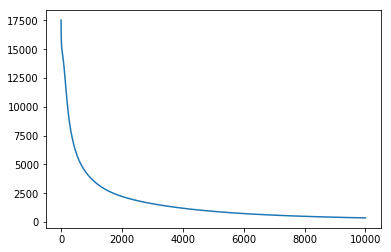

In [79]:
plt.plot(error_list)

In [80]:
Zhat_Train, Yhat_Train = NN_forward(X_Train, W, B, AF)

In [81]:
error_Train = find_error(Y_Train, Yhat_Train[-1], 'Multiclass')

In [82]:
error_Train

0.8491508491508492

# 5. Make Prediction

In [83]:
Zhat_Test, Yhat_Test = NN_forward(X_Test, W, B, AF)

In [84]:
error_Test = find_error(Y_Test, Yhat_Test[-1], 'Multiclass')

In [85]:
error_Test

6.565656565656566

Predicted: ก, Actual: ก


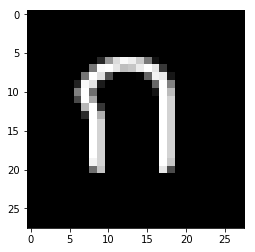

Predicted: ข, Actual: ข


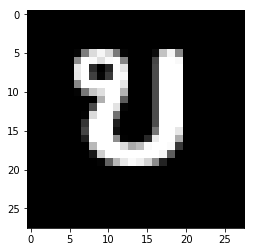

Predicted: ฃ, Actual: ฃ


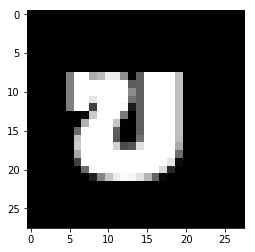

Predicted: ฅ, Actual: ค


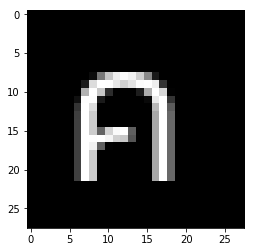

Predicted: ฅ, Actual: ฅ


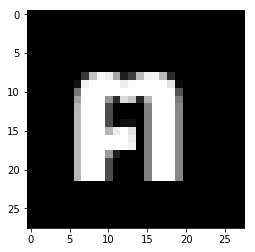

Predicted: ฆ, Actual: ฆ


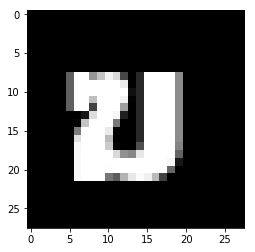

Predicted: ง, Actual: ง


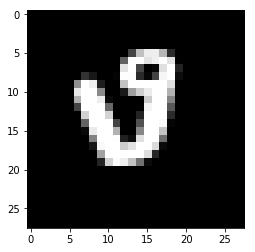

Predicted: จ, Actual: จ


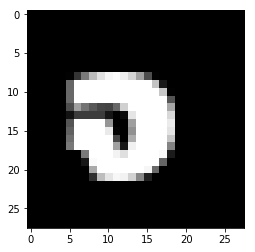

Predicted: ฉ, Actual: ฉ


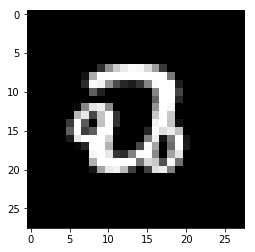

Predicted: ข, Actual: ช


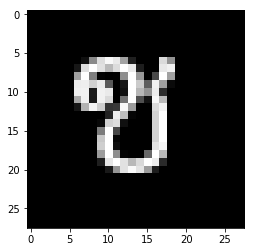

Predicted: ซ, Actual: ซ


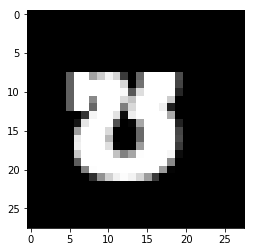

Predicted: ฌ, Actual: ฌ


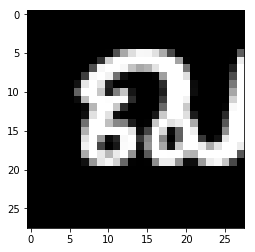

Predicted: ญ, Actual: ญ


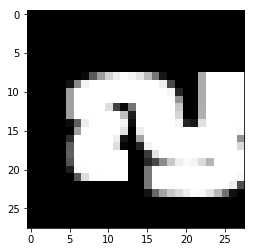

Predicted: ฎ, Actual: ฎ


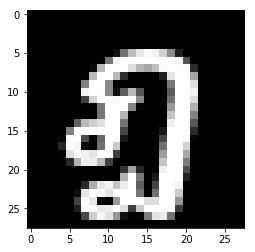

Predicted: ฏ, Actual: ฏ


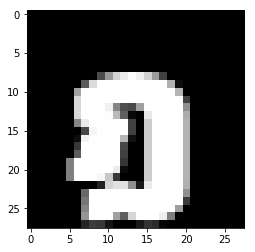

Predicted: ฐ, Actual: ฐ


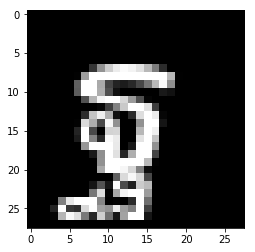

Predicted: ฑ, Actual: ฑ


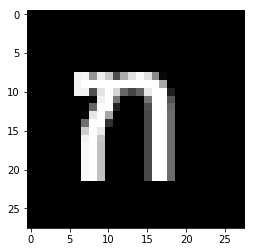

Predicted: ฒ, Actual: ฒ


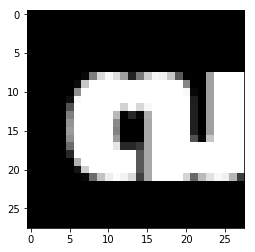

Predicted: ณ, Actual: ณ


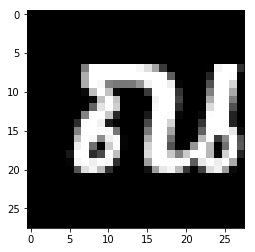

Predicted: ด, Actual: ด


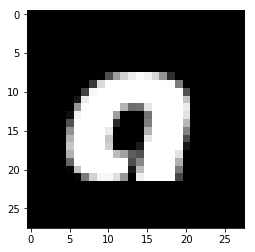

Predicted: ต, Actual: ต


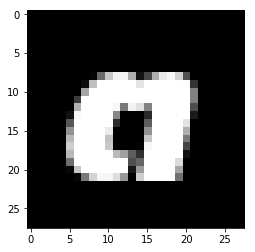

Predicted: ถ, Actual: ถ


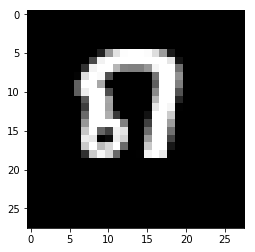

Predicted: ท, Actual: ท


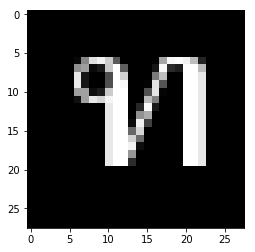

Predicted: ธ, Actual: ธ


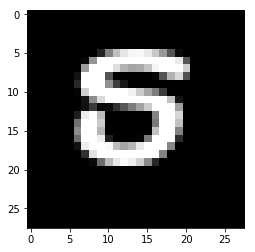

Predicted: น, Actual: น


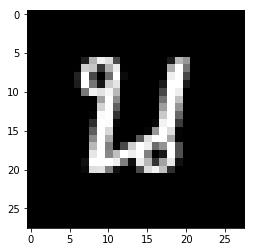

Predicted: บ, Actual: บ


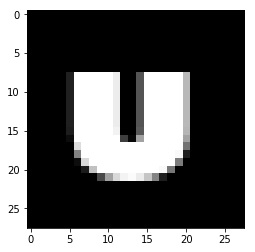

Predicted: ป, Actual: ป


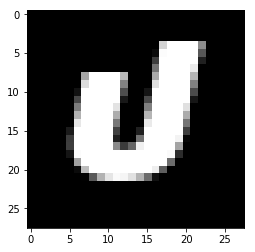

Predicted: ผ, Actual: ผ


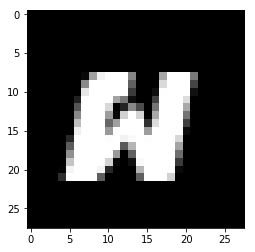

Predicted: ฝ, Actual: ฝ


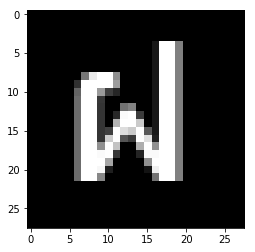

Predicted: พ, Actual: พ


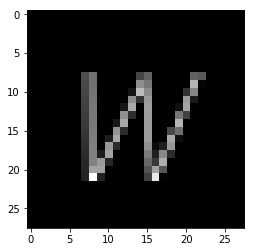

Predicted: ฟ, Actual: ฟ


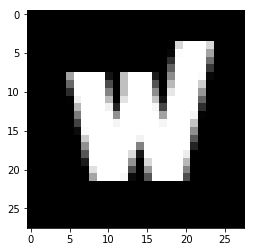

Predicted: ภ, Actual: ภ


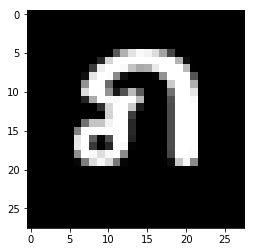

Predicted: ม, Actual: ม


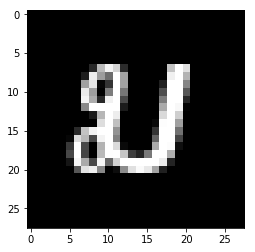

Predicted: ย, Actual: ย


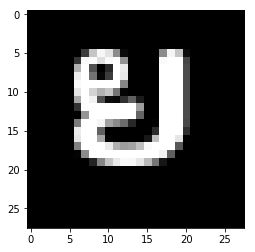

Predicted: ร, Actual: ร


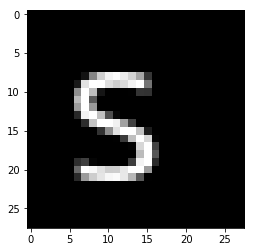

Predicted: ล, Actual: ล


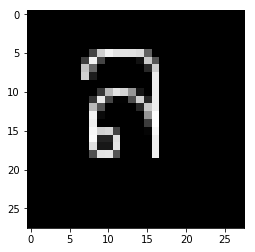

Predicted: ว, Actual: ว


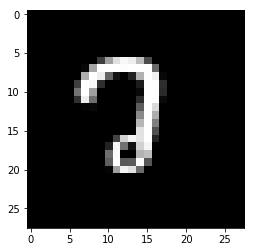

Predicted: ศ, Actual: ศ


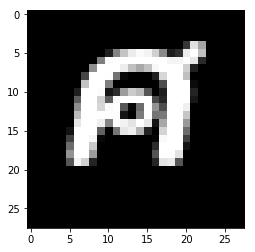

Predicted: ษ, Actual: ษ


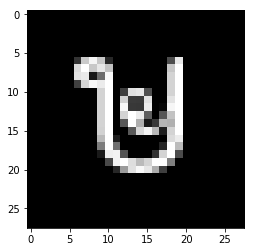

Predicted: ส, Actual: ส


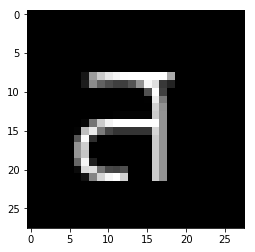

Predicted: ห, Actual: ห


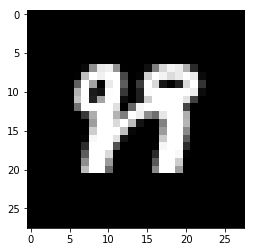

Predicted: ฬ, Actual: ฬ


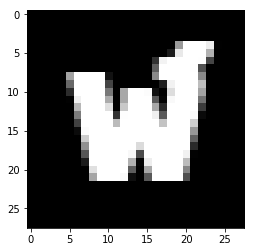

Predicted: จ, Actual: อ


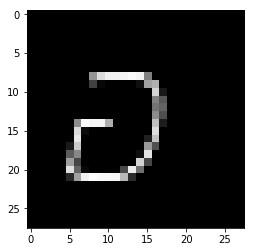

Predicted: ฮ, Actual: ฮ


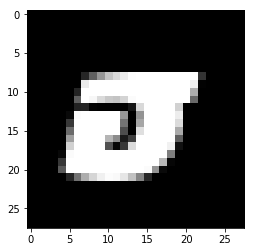

In [86]:
thai_char = ['ก','ข','ฃ','ค','ฅ','ฆ','ง','จ','ฉ','ช','ซ','ฌ','ญ','ฎ','ฏ','ฐ','ฑ','ฒ','ณ','ด','ต','ถ','ท','ธ','น','บ','ป','ผ','ฝ','พ','ฟ','ภ','ม','ย','ร','ล','ว','ศ','ษ','ส','ห','ฬ','อ','ฮ']

for i in range(0, 396, 9):
    image = image_test[i]
    label = label_test[i]
    
    predicted = np.argmax(Yhat_Test[-1], axis=1)[i]
    
    # plt.title('Predicted: {}, Actual: {}'.format(thai_char[int(predicted)], thai_char[int(label)]))
    print('Predicted: {}, Actual: {}'.format(thai_char[int(predicted)], thai_char[int(label)]))
    plt.imshow(image.reshape(28,28), cmap='gray')
    plt.show()